# A first test case with SHARPy
This notebook explains how to create a prismatic cantilever and flexible wing in SHARPy. It aims to provide a big picture about the simulations available in SHARPy describing the very fundamental concepts. 

This notebook requires around two hours to be completed.

## Generation of the aeroelastic model
This section explains how to generate the input files for SHARPy including the structure, the aerodynamics and the simulation details.

In [1]:
# Loading of the used packages
import numpy as np              # basic mathematical and array functions
import os                       # Functions related to the operating system
import matplotlib.pyplot as plt # Plotting library

import sharpy.sharpy_main                  # Run SHARPy inside jupyter notebooks
import sharpy.utils.plotutils as pu        # Plotting utilities
from sharpy.utils.constants import deg2rad # Constant to conver degrees to radians

import sharpy.utils.generate_cases as gc

The [generate cases](https://ic-sharpy.readthedocs.io/en/main/includes/utils/generate_cases/index.html) module of SHARPy includes a number of templates for the creation of simple cases using common parameters as inputs. It also removes clutter from this notebook.

The following cell configures the plotting library to show the next graphics, it is not part of SHARPy.

In [2]:
%%capture
! pip install plotly

### Define the problem parameters
In this section, we define the basic parameters to generate a model for the wing shown in the image below. We use SI units for all variables.

In [3]:
%config InlineBackend.figure_format = 'svg'
from IPython.display import Image
url = ('https://raw.githubusercontent.com/ImperialCollegeLondon/sharpy/dev_example/docs/' + 
       'source/content/example_notebooks/images/simple_wing_scheme.png')
Image(url=url, width=800)

In [4]:
# Geometry
chord = 1.         # Chord of the wing  |  Set to 1 by default
aspect_ratio = 16. # Ratio between lenght and chord: aspect_ratio = length/chord  |  Set to 16 by default
wake_length = 50   # Length of the wake in chord lengths  |  Set to 50 by default

# Discretization
num_node = 21           # Number of nodes in the structural discretisation
                        # The number of nodes will also define the aerodynamic panels in the 
                        # spanwise direction  |  Set to 21 by default
num_chord_panels = 4    # Number of aerodynamic panels in the chordwise direction  |  Set to 4 by default
num_points_camber = 200 # The camber line of the wing will be defined by a series of (x,y)
                        # coordintes. Here, we define the size of the (x,y) vectors  |  Set to 200 by default

# Structural properties of the beam cross section
mass_per_unit_length = 0.75 # Mass per unit length  |  Set to 0.75 by default
mass_iner_x = 0.1           # Mass inertia around the local x axis  |  Set to 0.1 by default
mass_iner_y = 0.05          # Mass inertia around the local y axis  |  Set to 0.05 by default
mass_iner_z = 0.05          # Mass inertia around the local z axis  |  Set to 0.05 by default
pos_cg_B = np.zeros((3))    # position of the centre of mass with respect to the elastic axis
EA = 1e7                    # Axial stiffness  |  Set to 1e7 by default
GAy = 1e6                   # Shear stiffness in the local y axis  |  Set to 1e6 by default
GAz = 1e6                   # Shear stiffness in the local z axis  |  Set to 1e6 by default
GJ = 1e4                    # Torsional stiffness  |  Set to 1e4 by default
EIy = 2e4                   # Bending stiffness around the flapwise direction  |  Set to 2e4 by default
EIz = 5e6                   # Bending stiffness around the edgewise direction  |  Set to 5e6 by default

# Operation
WSP = 2.0                # Wind speed  |  Set to 2.0 by default
air_density = 0.1       # Air density  |  Set to 0.1 by default

# Time discretization
end_time = 5.0                  # End time of the simulation  |  Set to 5.0 by default
dt = chord/num_chord_panels/WSP # Always keep one timestep per panel

First, we are going to compute the static equilibrium of the wing at an angle of attack (``aoa_ini_deg``). Next, we will change the angle of attack to ``aoa_end_deg`` and we will compute the dynamic response of the wing. Keep in mind we are not changing the angle of attack of the wing itself in these simulations but of the wind flowing toward it, which has the same effect.

In [5]:
aoa_ini_deg = 2.        # Angle of attack at the beginning of the simulation  |  Set to 2 by default
aoa_end_deg = 1.        # Angle of attack at the end of the simulation  |  Set to 1 by default

For now, we keep the size of the wake panels equal to the distance covered by the flow in one time step. 

### Structural model

This section creates a class called ``AeroelasticInformation``. This class is not directly used by SHARPy, it can be thought of as an intermediate step between common engineering inputs and the input information that SHARPy needs. 

It has many functionalities (rotate objects, assembly simple strucures together ...) which can be looked up in the [documentation](https://ic-sharpy.readthedocs.io/en/main/includes/utils/generate_cases/index.html).

Let's initialise an Aeroelastic system that will include a ``StructuralInformation`` class and an ``AerodynamicInformation`` class:

In [6]:
wing = gc.AeroelasticInformation()

The attibutes that have to be defined (not all of them are compulsory) can be displayed with the code below. They constitute the input parameters to SHARPy and their names are intuitive, however, a complete description of the input variables to SHARPy can be found in the documentation: 
[structural inputs](https://ic-sharpy.readthedocs.io/en/main/content/casefiles.html#fem-file) and [aerodynamic inputs](https://ic-sharpy.readthedocs.io/en/main/content/casefiles.html#aerodynamics-file)

For example, the structural properties are:

In [7]:
wing.StructuralInformation.__dict__.keys()

dict_keys(['num_node_elem', 'num_node', 'num_elem', 'coordinates', 'connectivities', 'elem_stiffness', 'stiffness_db', 'elem_mass', 'mass_db', 'frame_of_reference_delta', 'structural_twist', 'boundary_conditions', 'beam_number', 'body_number', 'app_forces', 'lumped_mass_nodes', 'lumped_mass', 'lumped_mass_inertia', 'lumped_mass_position', 'lumped_mass_mat', 'lumped_mass_mat_nodes'])

For example, the connectivities between the nodes required by the finite element solver are empty so far:

In [8]:
print(wing.StructuralInformation.connectivities)

None


For a list of  methods that allow us to modify the structure, Check the [documentation ](https://ic-sharpy.readthedocs.io/en/main/includes/utils/generate_cases/index.html).

First, we need to define the basic characteristics of the equations as the number of nodes, the number of nodes per element, the number of elements and the location of the nodes in the space:

In [9]:
# Define the number of nodes and the number of nodes per element
wing.StructuralInformation.num_node = num_node
wing.StructuralInformation.num_node_elem = 3
# Compute the number of elements assuming basic connections
wing.StructuralInformation.compute_basic_num_elem()

In [10]:
# Generate an array with the location of the nodes
node_r = np.zeros((num_node, 3))
node_r[:,1] = np.linspace(0, chord*aspect_ratio, num_node)
print(node_r)

[[ 0.   0.   0. ]
 [ 0.   0.8  0. ]
 [ 0.   1.6  0. ]
 [ 0.   2.4  0. ]
 [ 0.   3.2  0. ]
 [ 0.   4.   0. ]
 [ 0.   4.8  0. ]
 [ 0.   5.6  0. ]
 [ 0.   6.4  0. ]
 [ 0.   7.2  0. ]
 [ 0.   8.   0. ]
 [ 0.   8.8  0. ]
 [ 0.   9.6  0. ]
 [ 0.  10.4  0. ]
 [ 0.  11.2  0. ]
 [ 0.  12.   0. ]
 [ 0.  12.8  0. ]
 [ 0.  13.6  0. ]
 [ 0.  14.4  0. ]
 [ 0.  15.2  0. ]
 [ 0.  16.   0. ]]


The following function creates a uniform beam from the previous parameters. On top of assigning the previous parameters, it defines other variables such as the connectivities between nodes.

In [11]:
wing.StructuralInformation.generate_uniform_beam(node_r,
                    mass_per_unit_length,
                    mass_iner_x,
                    mass_iner_y,
                    mass_iner_z,
                    pos_cg_B,
                    EA,
                    GAy,
                    GAz,
                    GJ,
                    EIy,
                    EIz,
                    num_node_elem = wing.StructuralInformation.num_node_elem,
                    y_BFoR = 'x_AFoR',
                    num_lumped_mass=0)

If we now show the connectivities between nodes, the function has created them for us. [Further information](https://ic-sharpy.readthedocs.io/en/main/content/casefiles.html?highlight=connectivities#fem-file)

In [12]:
print(wing.StructuralInformation.connectivities)

[[ 0  2  1]
 [ 2  4  3]
 [ 4  6  5]
 [ 6  8  7]
 [ 8 10  9]
 [10 12 11]
 [12 14 13]
 [14 16 15]
 [16 18 17]
 [18 20 19]]


Let's define the boundary conditions as clamped for node 0 and free for the last node (-1), where 1 denotes a clamped point and -1 denotes a free point. [Further information](https://ic-sharpy.readthedocs.io/en/main/content/casefiles.html?highlight=boundary#fem-file)

In [13]:
wing.StructuralInformation.boundary_conditions[0] = 1
wing.StructuralInformation.boundary_conditions[-1] = -1

### Aerodynamics
We need to define the number of panels in the wake (``wake_panels``) and the camber line of the wing which, in this case, is flat. [Further information](https://ic-sharpy.readthedocs.io/en/main/content/casefiles.html#aerodynamics-file)

In [14]:
# Compute the number of panels in the wake (streamwise direction) based on the previous paramete
wake_panels = int(wake_length*chord/dt)

# Define the coordinates of the camber line of the wing
wing_camber = np.zeros((1, num_points_camber, 2))
wing_camber[0, :, 0] = np.linspace(0, 1, num_points_camber)

The following function creates an aerodynamic surface uniform on top of the beam that we have already created.

In [15]:
# Generate blade aerodynamics
wing.AerodynamicInformation.create_one_uniform_aerodynamics(wing.StructuralInformation,
                                 chord = chord,
                                 twist = 0.,
                                 sweep = 0.,
                                 num_chord_panels = num_chord_panels,
                                 m_distribution = 'uniform',
                                 elastic_axis = 0.5,
                                 num_points_camber = num_points_camber,
                                 airfoil = wing_camber)

### Summary
Now, we have all the inputs that we need for SHARPy. In this section, a first simulation with SHARPy is run. However, it will perform no computation, it will just load the data so we can plot the system we have just created.

SHARPy runs a series of [solvers](https://ic-sharpy.readthedocs.io/en/main/content/solvers.html) and [postprocessors](https://ic-sharpy.readthedocs.io/en/main/content/postproc.html) in the order indicated by the ``flow`` variable in the ``SHARPy`` dictionary.

The ``generate cases`` module also allows us to show all the avaiable solvers and all the parameters they accept as inputs. To do so, we need to run the following commands:

In [16]:
# Gather data about available solvers
SimInfo = gc.SimulationInformation() # Initialises the SimulationInformation class
SimInfo.set_default_values()         # Assigns the default values to all the solvers

# Print the available solvers and postprocessors
for key in SimInfo.solvers.keys():
    print(key)

_BaseStructural
AerogridLoader
BeamLoader
DynamicCoupled
DynamicUVLM
InitialAeroelasticLoader
LinDynamicSim
LinearAssembler
Modal
NoAero
NonLinearDynamic
NonLinearDynamicCoupledStep
NonLinearDynamicMultibody
NonLinearDynamicPrescribedStep
NonLinearStatic
NoStructural
PrescribedUvlm
RigidDynamicCoupledStep
RigidDynamicPrescribedStep
StaticCoupled
StaticTrim
StaticUvlm
StepLinearUVLM
StepUvlm
_BaseTimeIntegrator
NewmarkBeta
GeneralisedAlpha
Trim
UpdatePickle
StabilityDerivatives
WriteVariablesTime
SHARPy
SaveData
BeamLoads
UDPout
SaveParametricCase
AerogridPlot
Cleanup
PlotFlowField
FrequencyResponse
AsymptoticStability
LiftDistribution
AeroForcesCalculator
StallCheck
BeamPlot
PickleData
DynamicControlSurface
FloatingForces
TurbVelocityField
TrajectoryGenerator
PolarCorrection
EfficiencyCorrection
ModifyStructure
GustVelocityField
SteadyVelocityField
HelicoidalWake
BumpVelocityField
GridBox
StraightWake
TurbVelocityFieldBts
ShearVelocityField
BladePitchPid
ControlSurfacePidController
Tak

As an example, let's print the input parameters of the ``BeamLoader`` solver. This solver is in charge of loading the structural infromation.

In [17]:
SimInfo.solvers['BeamLoader']

{'unsteady': True, 'orientation': [1.0, 0, 0, 0], 'for_pos': [0.0, 0, 0]}

The following dictionary defines the basic inputs of SHARPy including the solvers to be run (``flow`` variable), the case name and the route in the file system. In this case we are turning off the screen output because we are not running any computation; it is useless.

In [18]:
SimInfo.solvers['SHARPy']['flow'] = ['BeamLoader',
                        'AerogridLoader']

SimInfo.solvers['SHARPy']['case'] = 'plot'
SimInfo.solvers['SHARPy']['route'] = './'
SimInfo.solvers['SHARPy']['write_screen'] = 'off'

We do not modify any of the default input paramteters in ``BeamLoader`` but we need to define the initial wake shape that we want and its size (``wake_panels``).

In [19]:
SimInfo.solvers['AerogridLoader']['unsteady'] = 'on'
SimInfo.solvers['AerogridLoader']['mstar'] = wake_panels
SimInfo.solvers['AerogridLoader']['freestream_dir'] = np.array([1.,0.,0.])
SimInfo.solvers['AerogridLoader']['wake_shape_generator'] = 'StraightWake'
SimInfo.solvers['AerogridLoader']['wake_shape_generator_input'] = {'u_inf': WSP,
                                                                   'u_inf_direction' : np.array(
                                                                                         [np.cos(aoa_ini_deg*deg2rad),
                                                                                         0.,
                                                                                         np.sin(aoa_ini_deg*deg2rad)]),
                                                                   'dt': dt}

The following functions write the input files needed by SHARPy.

In [20]:
gc.clean_test_files(SimInfo.solvers['SHARPy']['route'], SimInfo.solvers['SHARPy']['case'])
wing.generate_h5_files(SimInfo.solvers['SHARPy']['route'], SimInfo.solvers['SHARPy']['case'])
SimInfo.generate_solver_file()

The following line of code runs SHARPy inside of jupyter notebook. It is equivalent to running this in a terminal, with: ``sharpy plot.sharpy`` being "plot", the case name defined above.

In [21]:
sharpy_output = sharpy.sharpy_main.main(['',
                                         SimInfo.solvers['SHARPy']['route'] +
                                         SimInfo.solvers['SHARPy']['case'] +
                                         '.sharpy'])

fatal: not a git repository (or any of the parent directories): .git


Let's plot the case we have created. The function below provides a quick way of generating an interactive plot but it is not suitable for large cases. Luckily SHARPy has other more complex plotting capabilities.

If you download the original [jupyter notebook](https://ic-sharpy.readthedocs.io/en/main/content/examples.html), change the geometric parameters above and rerun the notebook, you will see its impact on the geometry.

In our simulations only the first 6 wake panels are plotted for the sake of efficiency. This can be changed by changing the number within ```minus_mstar```.

Setting ```plotly``` to ```False``` will not plot a graph.

```custom_scaling``` is a toggleable feature that realistically models the wing's aspect ratio and compresses the z axis. It is disabled by default.

If ```custom_scaling``` is toggled on,```z_compression``` determines how compressed the z axis is. By default this is set to 0.5.

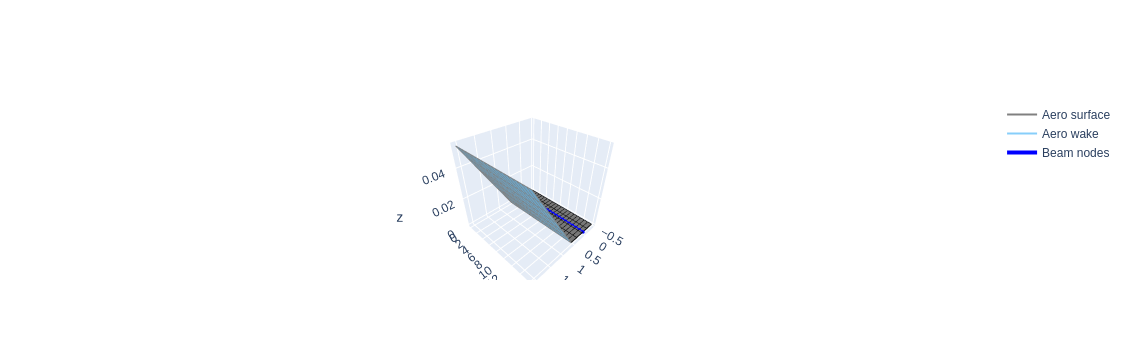

In [22]:
pu.plot_timestep(sharpy_output, tstep=-1, minus_mstar=(wake_panels - 6), plotly=True,custom_scaling=False,z_compression=0.5)

## Static simulation
Next, we will run a static simulation of the previous system. We have already defined the required inputs for ``BeamLoader`` and ``AerogridLoader`` but we need to define the static solvers. We are going to use an FSI solver (``StaticCoupled``) that will include a structural solver (``NonLinearStatic``) and aerodynamic solver (``StaticUvlm``). 

We will use most of the default values but redefine some of them:
- We assign the air density to all the solvers that need it
- We turn off the gravity on the structural solver
- We use a horseshoe solution without roll up for the aerodynamics
- We define the velocity field against the wing
- We do not use load steps in the FSI solver

In the documentation you can find further information about the [modular framework](https://ic-sharpy.readthedocs.io/en/main/content/casefiles.html#modular-framework) and about the [solvers](https://ic-sharpy.readthedocs.io/en/main/content/solvers.html) and their inputs. 

In [23]:
# Define the simulation
SimInfo.solvers['SHARPy']['flow'] = ['BeamLoader',
                        'AerogridLoader',
                        'StaticCoupled']

SimInfo.set_variable_all_dicts('rho', air_density)

SimInfo.solvers['SHARPy']['case'] = 'static'
SimInfo.solvers['SHARPy']['write_screen'] = 'on'

SimInfo.solvers['NonLinearStatic']['gravity_on'] = False

SimInfo.solvers['StaticUvlm']['horseshoe'] = True
SimInfo.solvers['StaticUvlm']['n_rollup'] = 0
SimInfo.solvers['StaticUvlm']['velocity_field_generator'] = 'SteadyVelocityField'
SimInfo.solvers['StaticUvlm']['velocity_field_input'] = {'u_inf' : WSP,
                                                         'u_inf_direction' : np.array(
                                                                                [np.cos(aoa_ini_deg*deg2rad),
                                                                                 0.,
                                                                                 np.sin(aoa_ini_deg*deg2rad)])}

SimInfo.solvers['StaticCoupled']['structural_solver'] = 'NonLinearStatic'
SimInfo.solvers['StaticCoupled']['structural_solver_settings'] = SimInfo.solvers['NonLinearStatic']
SimInfo.solvers['StaticCoupled']['aero_solver'] = 'StaticUvlm'
SimInfo.solvers['StaticCoupled']['aero_solver_settings'] = SimInfo.solvers['StaticUvlm']
SimInfo.solvers['StaticCoupled']['n_load_steps'] = 0

The following functions create the input files required by SHARPy. For further information check:
- [Configuration file](https://ic-sharpy.readthedocs.io/en/main/content/casefiles.html#solver-configuration-file)
- [FEM input file](https://ic-sharpy.readthedocs.io/en/main/content/casefiles.html#fem-file)
- [Aerodynamic input file](https://ic-sharpy.readthedocs.io/en/main/content/casefiles.html#aerodynamics-file)


In [24]:
gc.clean_test_files(SimInfo.solvers['SHARPy']['route'], SimInfo.solvers['SHARPy']['case'])
SimInfo.generate_solver_file()
wing.generate_h5_files(SimInfo.solvers['SHARPy']['route'], SimInfo.solvers['SHARPy']['case'])

In [25]:
# Running SHARPy again inside jupyter
sharpy_output = sharpy.sharpy_main.main(['',
                                         SimInfo.solvers['SHARPy']['route'] +
                                         SimInfo.solvers['SHARPy']['case'] +
                                         '.sharpy'])

--------------------------------------------------------------------------------
            ######  ##     ##    ###    ########  ########  ##    ##
           ##    ## ##     ##   ## ##   ##     ## ##     ##  ##  ##
           ##       ##     ##  ##   ##  ##     ## ##     ##   ####
            ######  ######### ##     ## ########  ########     ##
                 ## ##     ## ######### ##   ##   ##           ##
           ##    ## ##     ## ##     ## ##    ##  ##           ##
            ######  ##     ## ##     ## ##     ## ##           ##
--------------------------------------------------------------------------------
Aeroelastics Lab, Aeronautics Department.
    Copyright (c), Imperial College London.
    All rights reserved.
    License available at https://github.com/imperialcollegelondon/sharpy
Running SHARPy from /home/loca/Downloads/sharpy copy/sharpy/docs/source/content/example_notebooks
SHARPy being run is in /home/loca/anaconda3/envs/sharpy/lib/python3.10/site-packages
SHA

fatal: not a git repository (or any of the parent directories): .git


Generating an instance of StaticCoupled
Generating an instance of NonLinearStatic
Generating an instance of StaticUvlm



|=====|=====|============|==========|==========|==========|==========|==========|==========|
|iter |step | log10(res) |    Fx    |    Fy    |    Fz    |    Mx    |    My    |    Mz    |
|=====|=====|============|==========|==========|==========|==========|==========|==========|
                      DeltaF      DeltaX         Res      ResRel      ResFrc   ResRelFrc      ResMmt   ResRelMmt         ErX       ErPos       ErPsi
LoadStep Subiter      DeltaF     DeltaX          Res      ResRel      ResFrc   ResRelFrc      ResMmt   ResRelMmt         ErX       ErPos       ErPsi
|  0  |  0  |  0.00000   | -0.0187  | -0.0006  |  0.6029  |  4.8229  |  0.1523  |  0.1495  |
                      DeltaF      DeltaX         Res      ResRel      ResFrc   ResRelFrc      ResMmt   ResRelMmt         ErX       ErPos       ErPsi
LoadStep Subiter      DeltaF     DeltaX          Res      R

The next function will plot the static equilibirium solution for the wing:

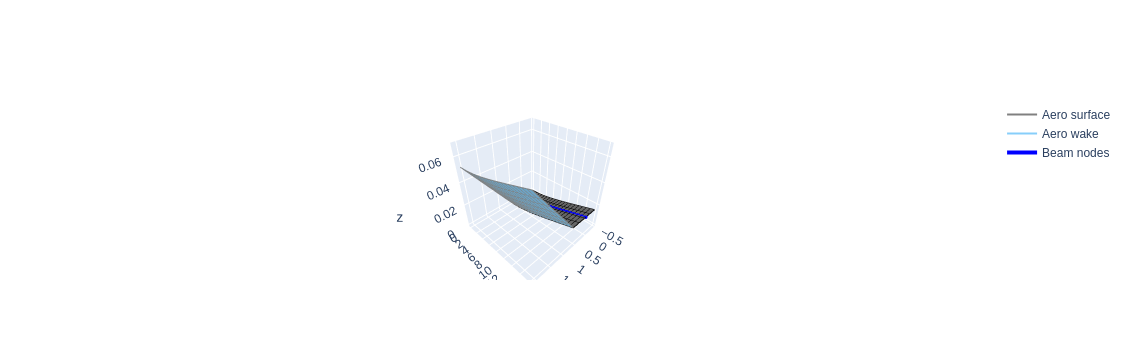

In [26]:
pu.plot_timestep(sharpy_output, tstep=-1, minus_mstar=(wake_panels - 6), plotly=True,custom_scaling=False,z_compression=0.5)

## Dynamic simulation
Finally, we will run a dynamic simulation after the previous static one. With that in mind, we will now include a dynamic FSI solver (``DynamicCoupled``)  in the simulation.

In [27]:
SimInfo.solvers['SHARPy']['flow'] = ['BeamLoader',
                        'AerogridLoader',
                        'StaticCoupled',
                        'DynamicCoupled']

SimInfo.solvers['SHARPy']['route'] = './'
SimInfo.solvers['SHARPy']['case'] = 'dynamic'

We need information about the time step and the number of iterations:

In [28]:
# Compute the number of time steps needed based on the previous parameters
time_steps = int(end_time/dt)

# Define the time step and the number of time steps in every solver that requires them as input
SimInfo.set_variable_all_dicts('dt', dt)
SimInfo.define_num_steps(time_steps)

We define the approximation we are going to use for the wake convection (``convection_scheme``), the velocity field and deactivate the gravity.

We are going to use an FSI solver (``DynamicCoupled``) that couples a structual solver (``NonLinearDynamicPrescribedStep``) and aerodynamic solver (``StepUvlm``).

Moreover, the FSI solver runs a series of postprocessors after each time step. Specifically, it will save a plot of the structure (``BeamPlot``) and of the aerodynamic surfaces (``AerogridPlot``).

In [29]:
SimInfo.solvers['StepUvlm']['convection_scheme'] = 2
SimInfo.solvers['StaticUvlm']['velocity_field_generator'] = 'SteadyVelocityField'
SimInfo.solvers['StepUvlm']['velocity_field_input'] = {'u_inf' : WSP,
                                                       'u_inf_direction' : np.array(
                                                                              [np.cos(aoa_end_deg*deg2rad),
                                                                               0.,
                                                                               np.sin(aoa_end_deg*deg2rad)])}

SimInfo.solvers['NonLinearDynamicPrescribedStep']['gravity_on'] = False

SimInfo.solvers['DynamicCoupled']['structural_solver'] = 'NonLinearDynamicPrescribedStep'
SimInfo.solvers['DynamicCoupled']['structural_solver_settings'] = SimInfo.solvers['NonLinearDynamicPrescribedStep']
SimInfo.solvers['DynamicCoupled']['aero_solver'] = 'StepUvlm'
SimInfo.solvers['DynamicCoupled']['aero_solver_settings'] = SimInfo.solvers['StepUvlm']
SimInfo.solvers['DynamicCoupled']['postprocessors'] = ['BeamPlot', 'AerogridPlot']
SimInfo.solvers['DynamicCoupled']['postprocessors_settings'] = {'BeamPlot': SimInfo.solvers['BeamPlot'],
                                                             'AerogridPlot': SimInfo.solvers['AerogridPlot']}


Finally, we need to define the movement of the whole wing through its velocity and acceleration. In this case we want a clamped structure so we will set every thing to zero.

Moreover, we can define forces applied together with the aerodynamic ones. In this case they will be set to zero.

In [30]:
SimInfo.with_forced_vel = True
SimInfo.for_vel = np.zeros((time_steps,6), dtype=float)
SimInfo.for_acc = np.zeros((time_steps,6), dtype=float)
SimInfo.with_dynamic_forces = True
SimInfo.dynamic_forces = np.zeros((time_steps,wing.StructuralInformation.num_node,6),
                                  dtype=float)

We write the input files required by SHARPy again:

In [31]:
gc.clean_test_files(SimInfo.solvers['SHARPy']['route'], SimInfo.solvers['SHARPy']['case'])
wing.generate_h5_files(SimInfo.solvers['SHARPy']['route'], SimInfo.solvers['SHARPy']['case'])
SimInfo.generate_solver_file()
SimInfo.generate_dyn_file(time_steps)

And we run the simulation:

In [32]:
sharpy_output = sharpy.sharpy_main.main(['',
                                         SimInfo.solvers['SHARPy']['route'] +
                                         SimInfo.solvers['SHARPy']['case'] +
                                         '.sharpy'])

--------------------------------------------------------------------------------
            ######  ##     ##    ###    ########  ########  ##    ##
           ##    ## ##     ##   ## ##   ##     ## ##     ##  ##  ##
           ##       ##     ##  ##   ##  ##     ## ##     ##   ####
            ######  ######### ##     ## ########  ########     ##
                 ## ##     ## ######### ##   ##   ##           ##
           ##    ## ##     ## ##     ## ##    ##  ##           ##
            ######  ##     ## ##     ## ##     ## ##           ##
--------------------------------------------------------------------------------
Aeroelastics Lab, Aeronautics Department.
    Copyright (c), Imperial College London.
    All rights reserved.
    License available at https://github.com/imperialcollegelondon/sharpy
Running SHARPy from /home/loca/Downloads/sharpy copy/sharpy/docs/source/content/example_notebooks
SHARPy being run is in /home/loca/anaconda3/envs/sharpy/lib/python3.10/site-packages
SHA

fatal: not a git repository (or any of the parent directories): .git





|=====|=====|============|==========|==========|==========|==========|==========|==========|
|iter |step | log10(res) |    Fx    |    Fy    |    Fz    |    Mx    |    My    |    Mz    |
|=====|=====|============|==========|==========|==========|==========|==========|==========|
                      DeltaF      DeltaX         Res      ResRel      ResFrc   ResRelFrc      ResMmt   ResRelMmt         ErX       ErPos       ErPsi
LoadStep Subiter      DeltaF     DeltaX          Res      ResRel      ResFrc   ResRelFrc      ResMmt   ResRelMmt         ErX       ErPos       ErPsi
|  0  |  0  |  0.00000   | -0.0187  | -0.0006  |  0.6029  |  4.8229  |  0.1523  |  0.1495  |
                      DeltaF      DeltaX         Res      ResRel      ResFrc   ResRelFrc      ResMmt   ResRelMmt         ErX       ErPos       ErPsi
LoadStep Subiter      DeltaF     DeltaX          Res      ResRel      ResFrc   ResRelFrc      ResMmt   ResRelMmt         ErX       ErPos       ErPsi
|  1  |  0  |  -9.22874  | -0

This is the plot of the wing at the end of the simulation:

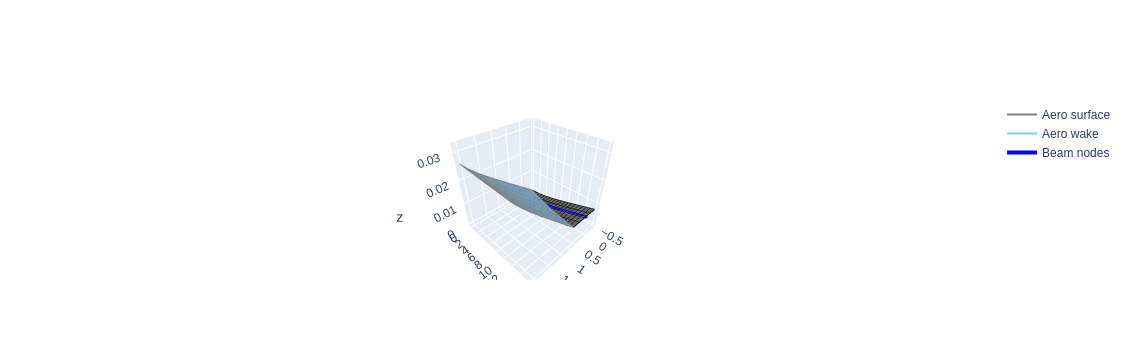

In [33]:
pu.plot_timestep(sharpy_output, tstep=-1, minus_mstar=(wake_panels - 6), plotly=True,custom_scaling=False,z_compression=0.5)

## Postprocessing
As an example, we are going to plot the evolution of the tip position along time:

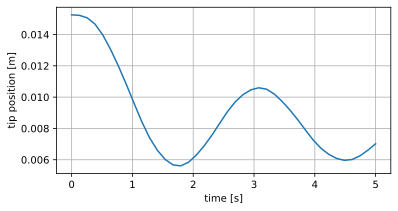

In [34]:
time = np.linspace(0, dt*time_steps, time_steps)
tip_pos = np.zeros((time_steps))
for it in range(time_steps):
    tip_pos[it] = sharpy_output.structure.timestep_info[it].pos[-1, 2]

fig, plots = plt.subplots(1, 1, figsize=(6, 3))

plots.grid()
plots.set_xlabel("time [s]")
plots.set_ylabel("tip position [m]")
plots.plot(time, tip_pos, '-')

plt.show()

## Conclusions
This notebook provides the big picture of the simulations with SHARPy. We recommend to go through the [documentation](https://ic-sharpy.readthedocs.io/en/main/) with special attention to the [SHARPy file description](https://ic-sharpy.readthedocs.io/en/main/content/casefiles.html) and the [examples](https://ic-sharpy.readthedocs.io/en/main/content/examples.html).